# Spatial Distributions, Two-point correlation fucntions etc

Here I present plots of the spatial distribution of the Galaxies and calculate the two-point correlation function of the red/blue sample.

In [1]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=8):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=1.6*fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

## Import the catalog properties now

In [2]:
import pandas as pd

LSBG_df = pd.read_csv('LSBG_catalog.csv')

# Magnitudes
mag_g = LSBG_df['mag_gfm_g_corr'].values
mag_r = LSBG_df['mag_gfm_r_corr'].values
mag_i = LSBG_df['mag_gfm_i_corr'].values

# RA and DEC
RA = LSBG_df['ra_gfm'].values
DEC = LSBG_df['dec_gfm'].values

In [3]:
# Define the colors here
col_g_i = mag_g - mag_i
col_g_r = mag_g - mag_r
col_i_r = mag_i - mag_r


# Define the point in g-i color, that divides red from blue galaxies
med_g_i = 0.60510511

### Part I: Spatial Distribution Plots

In [4]:
import skymap as smap
from skymap import DESSkymap

In [5]:
ra_red = RA[col_g_i>med_g_i]
dec_red = DEC[col_g_i>med_g_i]
# ===================================================
ra_blue = RA[(col_g_i<med_g_i)]
dec_blue = DEC[(col_g_i<med_g_i)]

**Spatial Distribution plot of the red galaxies**

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2484: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


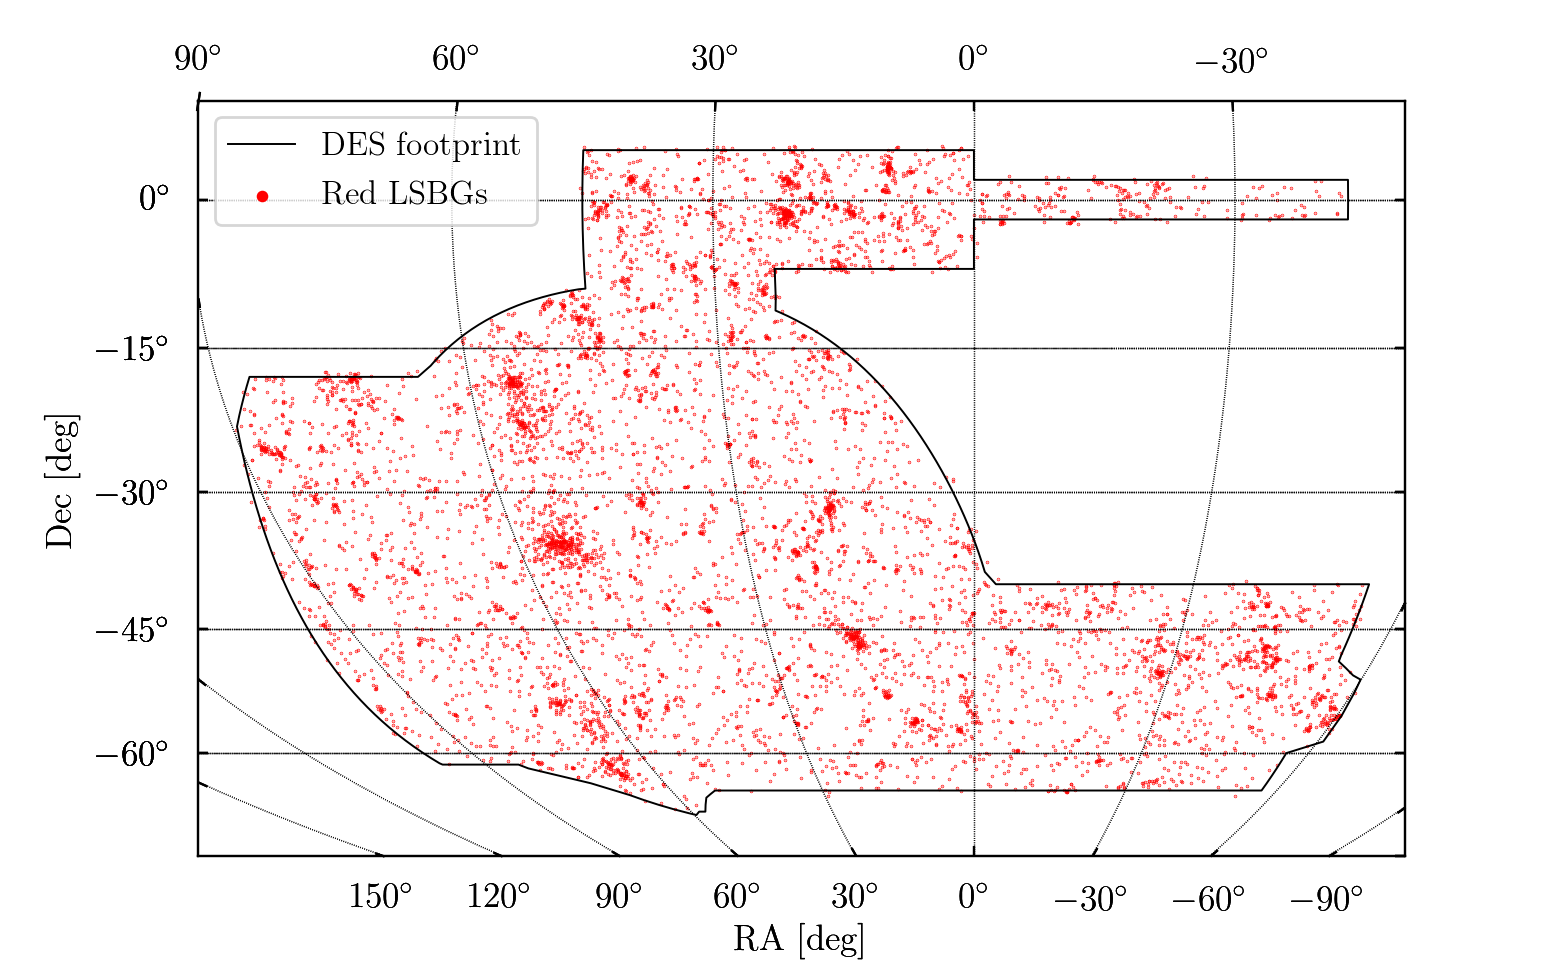

In [6]:
plt.figure(figsize = (8.0,5.0))

smap = DESSkymap()

smap.scatter(ra_red, dec_red, c='r',rasterized=True, s=0.05,latlon=True)
smap.draw_des(color='k',linewidth=0.7,label='DES footprint')

smap.scatter(0,20,c='red',s=10,alpha=1, label='Red LSBGs')

plt.xlabel("RA [deg]", fontsize=20)
plt.ylabel("Dec [deg]", fontsize=20)

plt.legend(frameon=True, loc='upper left', fontsize=12)
plt.tight_layout()
#plt.savefig('Footprint.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
plt.savefig('Reds.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()

**Spatial Distribution plot of the blue galaxies**

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2484: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


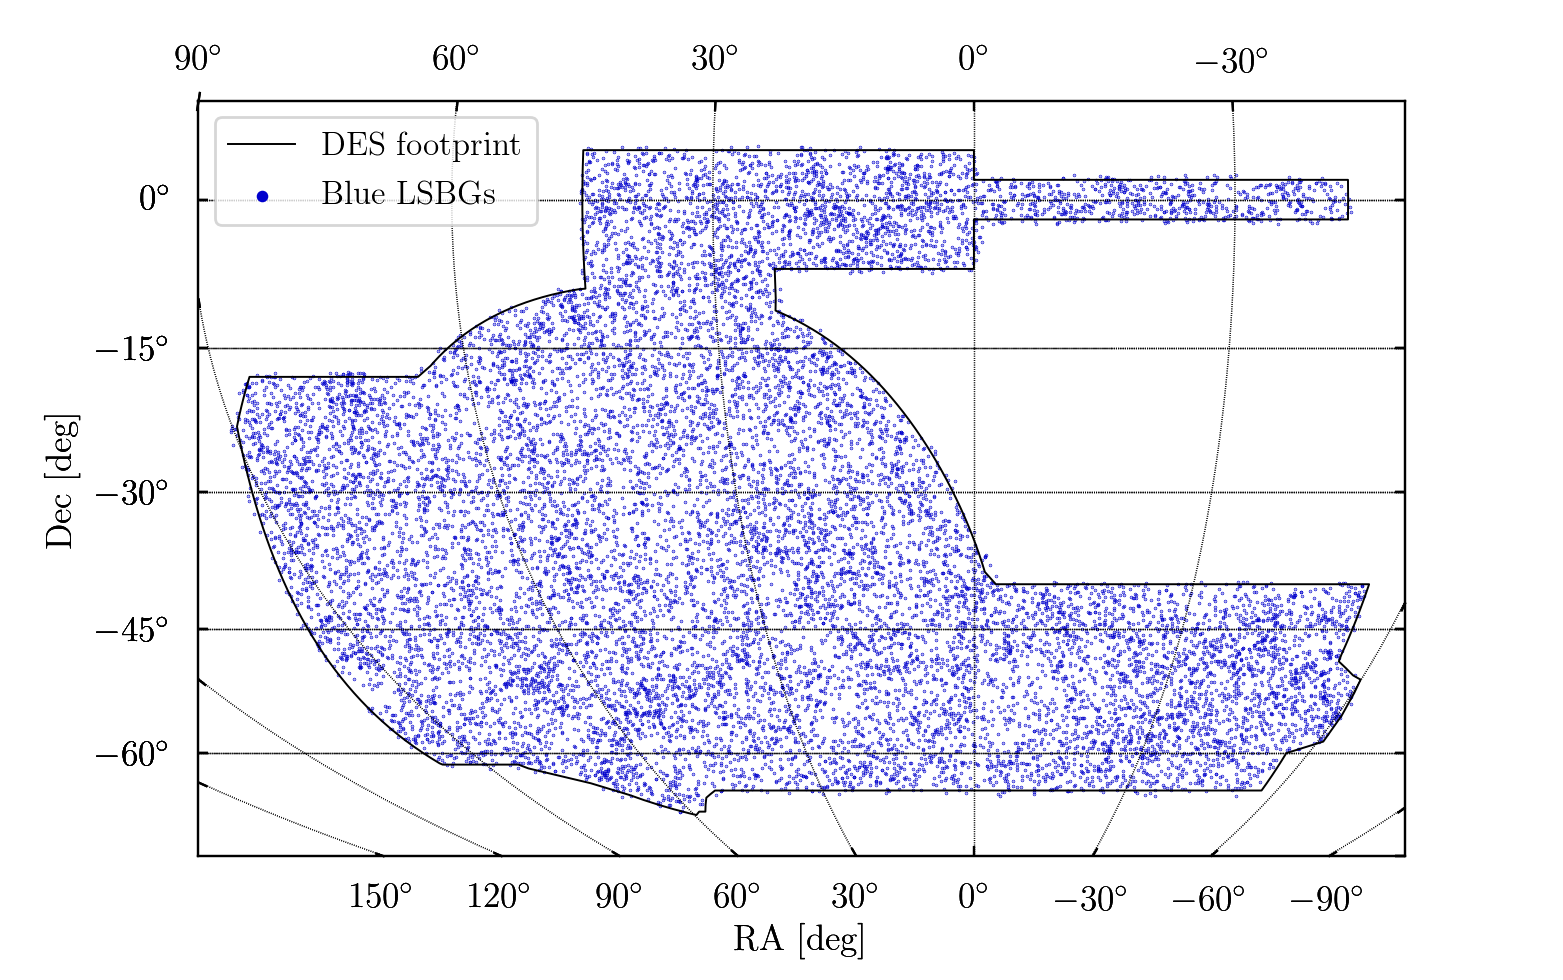

In [7]:
plt.figure(figsize = (8.0,5.0))

smap = DESSkymap()

smap.scatter(ra_blue, dec_blue, c='mediumblue',rasterized=True, s=0.05,latlon=True)
smap.draw_des(color='k',linewidth=0.7,label='DES footprint')

smap.scatter(0,20,c='mediumblue',s=10,alpha=1, label='Blue LSBGs')

plt.xlabel("RA [deg]", fontsize=20)
plt.ylabel("Dec [deg]", fontsize=20)

plt.legend(frameon=True, loc='upper left', fontsize=12)
plt.tight_layout()
#plt.savefig('Footprint.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
plt.savefig('Blues.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()

## Part II: Autocorrelation functions

In this part we calculate the two-point correlation functions.

In each case the errors are estimated using the jackknife approach; For $N$ jackknife resamplings, the estimation of the covariance is:

\begin{equation}
C_{ij} = \frac{N-1}{N} \sum_{k=1}^N (x_i^k - \bar{x}_i)(x_j^k - \bar{x}_j)
\end{equation}

where:

\begin{equation}
\bar{x}_i = \frac{1}{N}\sum_{k=1}^N x_i^k
\end{equation}

In [9]:
# First import some things we are gonna need
import treecorr
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord

#### Write a function that calculates Jackknife errors, given a data catalog and a random catalog

In [10]:
def Jackknife(ra_dat, dec_dat, ra_rand, dec_rand, N_samples):
    """
    Inputs
    ------------------------------------------
    ra_dat: the ra of the data catalog
    dec_dat: the dec of the data catalog
     
    ra_rand: the ra of the random catalog
    dec_rand: the dac of the random catalog
    
    Outputs
    ------------------------------------------
    Errors in the two-point calculation across different scales
    """
    
    # First of all create array to store the results of the evaluations of 
    # the two point correlation functions
    Xi_vect = np.zeros([N_samples,20]) 
    
    #Create array with length equal to the length of the sample and entries 0,1,...,len(sample)
    len_smpl = len(ra_dat) #length of the sample
    
    A = np.arange(len_smpl)
    #Create array where you randomly redistribute these 
    np.random.shuffle(A)
    
    #randomize the distribution of the ra, dec vectors of the data
    ra_dat_rn = ra_dat[A]
    dec_dat_rn = dec_dat[A]
    
    # Batch size
    batch = int(len_smpl/N_samples)
    
    # =====================================================================
    # =====================================================================
    
    # Let's make a catalog for the randoms
    rand = treecorr.Catalog(ra=ra_rand, dec=dec_rand, ra_units='radians', dec_units='radians')
    rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
    rr.process(rand)
    
    # =====================================================================
    # =====================================================================
    #Populate the Xi_vect
    for i in range(N_samples):
        # Points to keep
        init = i*batch #Initial points not to keep
        fin = (i+1)*batch #final points not to keep
        
        # Keep data where you have excluded one batch 
        ra_dat_loc = np.concatenate((ra_dat_rn[:init],ra_dat_rn[fin:]))
        dec_dat_loc = np.concatenate((dec_dat_rn[:init],dec_dat_rn[fin:]))
        
        # Create catalog using the above data 
        cat_dat_loc = treecorr.Catalog(ra=ra_dat_loc, dec=dec_dat_loc, ra_units='deg', dec_units='deg')
        dd_loc = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
        dd_loc.process(cat_dat_loc)
        
        #data - random catalog
        dr_loc = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
        dr_loc.process(cat_dat_loc, rand)
        
        # Calculate 2pt correlation function of the sample
        xi_loc, varxi_loc = dd_loc.calculateXi(rr, dr_loc)
        
        Xi_vect[i,:] = xi_loc
    
        
    # ======================================================================
    # ======================================================================
    # Define vector to store the errors
    Err_vect = np.zeros(20)
    
    for i in range(20):
        
        Xi_i = Xi_vect[:,i]
        mean_Xi_i = np.mean(Xi_i)
        diff_sq = (Xi_i - mean_Xi_i)**2.0
        sig_sq = ((N_samples - 1.0)/N_samples)*np.sum(diff_sq)

        Err_vect[i] = np.sqrt(sig_sq)
    
    return Err_vect    

#### Create a random catalog

In [11]:
# Open MAP 
# ==========================================
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')
conv = np.pi/180.
ra_min = -70.0*conv
ra_max = 110.*conv
dec_min = -70.*conv
dec_max = 10.*conv
# ========================
# ========================
rand_ra = np.random.uniform(ra_min, ra_max, 10**7)
rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), 10**7)
rand_dec = np.arcsin(rand_sindec)
# ========================

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [12]:
# Get the healpix indices of the randoms
HP_ind_rand = hp.ang2pix(4096, rand_ra/conv, rand_dec/conv, lonlat=True)

In [13]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1
LOCAL_mask_rand = DES_mask[HP_ind_rand]

# Keep those with LOCAL_mask = 1
rand_ra_pos = rand_ra[LOCAL_mask_rand==1]
rand_dec_pos = rand_dec[LOCAL_mask_rand==1]

# Calculate the two point correlation function of the mpz sample
# Let's make a catalog for the randoms
rand = treecorr.Catalog(ra=rand_ra_pos, dec=rand_dec_pos, ra_units='radians', dec_units='radians')
rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
rr.process(rand)

#### Split LSBGs according to color and make the plot

##### First for the red galaxies

In [14]:
# Create catalog of red galaxies
cat_red = treecorr.Catalog(ra=ra_red, dec=dec_red, ra_units='deg', dec_units='deg')
dd_red = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_red.process(cat_red)
dr_red = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_red.process(cat_red, rand)
# Calculate 2pt correlation function of the red sample
xi_red, varxi_red = dd_red.calculateXi(rr, dr_red)
r_red = np.exp(dd_red.meanlogr)
sig_red = np.sqrt(varxi_red)
# Calculate Jackknife errors
# Calculate red galaxies errors
Errors_red = Jackknife(ra_red, dec_red, rand_ra_pos, rand_dec_pos, 100)

##### For the blue galaxies now

In [15]:
# Create catalog of blue galaxies
cat_blue = treecorr.Catalog(ra=ra_blue, dec=dec_blue, ra_units='deg', dec_units='deg')
dd_blue = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_blue.process(cat_blue)
dr_blue = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_blue.process(cat_blue, rand)
#Calculate 2pt correlation function of the blue sample
xi_blue, varxi_blue = dd_blue.calculateXi(rr, dr_blue)
r_blue = np.exp(dd_blue.meanlogr)
sig_blue = np.sqrt(varxi_blue)
# Calculate Jackknife errors
# Calculate blue galaxies errors
Errors_blue = Jackknife(ra_blue, dec_blue, rand_ra_pos, rand_dec_pos, 100)

##### And for all galaxies

In [16]:
# Create catalog
cat_LSBG = treecorr.Catalog(ra=RA, dec=DEC, ra_units='deg', dec_units='deg')

dd_LSBG = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_LSBG.process(cat_LSBG)
# ===========================================================
# ===========================================================
dr_LSBG = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_LSBG.process(cat_LSBG, rand)
# ===========================================================
# Calculate 2pt correlation function of the total sample
xi_LSBG, varxi_LSBG = dd_LSBG.calculateXi(rr, dr_LSBG)
r_LSBG = np.exp(dd_LSBG.meanlogr)
# Calculate Jackknife errors
# Calculate LSBG errors
Errors_LSBG = Jackknife(RA, DEC, rand_ra_pos, rand_dec_pos, 100)

### Make a plot

In [17]:
def plot_pretty(dpi=200, fontsize=8):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [18]:
print(len(RA))

23790


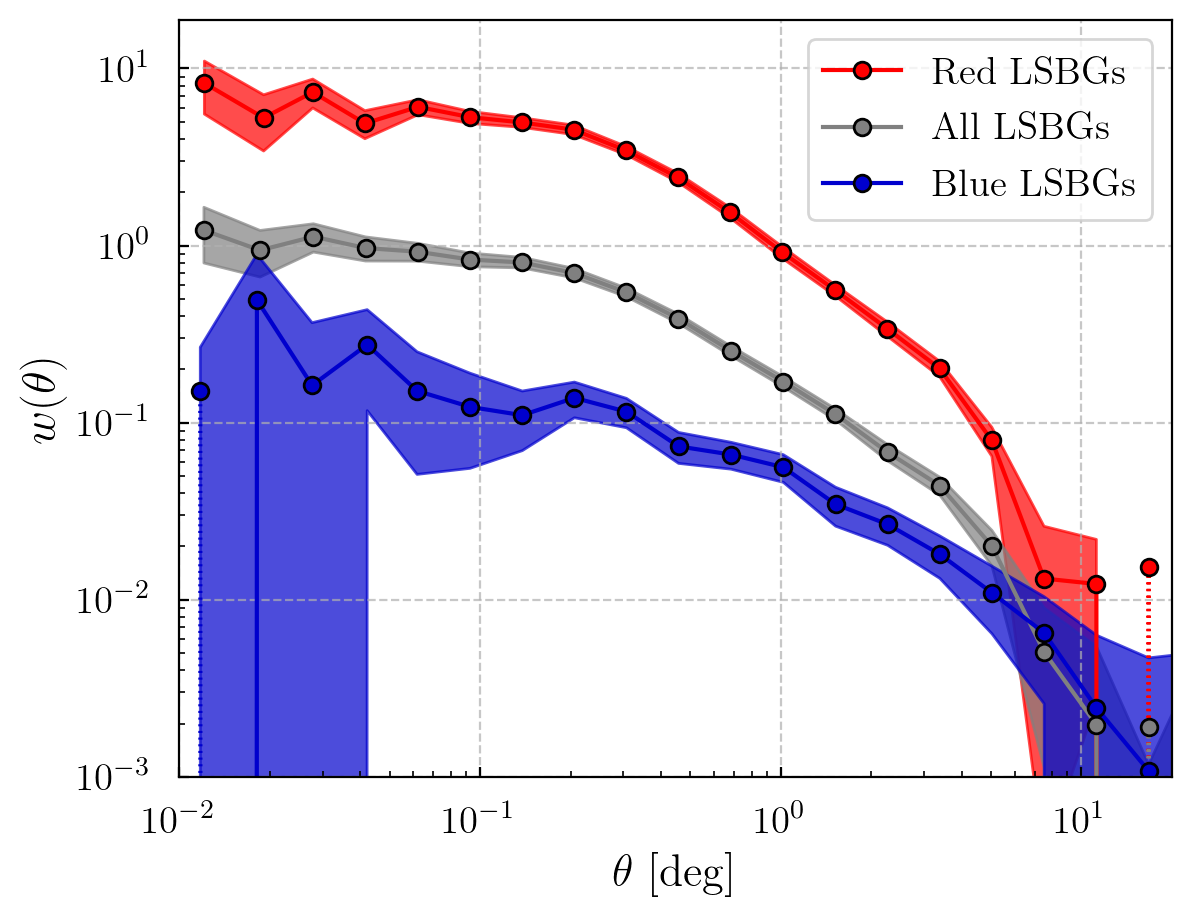

In [19]:
plt.figure(figsize = (6.,4.65))

# red galaxies
plt.plot(r_red, xi_red, color='r',marker='o', markeredgecolor='k', label='Red LSBGs')
plt.plot(r_red, -xi_red, color='r',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_red, xi_red-Errors_red, xi_red+Errors_red, color='r',
                 rasterized=True,alpha=0.7)

# All galaxies
plt.plot(r_LSBG, xi_LSBG, color='gray',marker='o', markeredgecolor='k', label='All LSBGs')
plt.plot(r_LSBG, -xi_LSBG, color='gray',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_LSBG, xi_LSBG-Errors_LSBG, xi_LSBG+Errors_LSBG, color='gray',
                 rasterized=True, alpha=0.7)


# blue galaxies
plt.plot(r_blue, xi_blue, color='mediumblue',marker='o', markeredgecolor='k', label='Blue LSBGs')
plt.plot(r_blue, -xi_blue, color='mediumblue',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_blue, xi_blue-Errors_blue, xi_blue+Errors_blue, color='mediumblue',
                 rasterized=True,alpha=0.7)


plt.grid(ls='--',alpha=0.7)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ [deg]', fontsize=16)



plt.ylabel(r'$w(\theta)$', fontsize=17)
plt.legend(frameon=True, loc='upper right', fontsize=14)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig('two_point_color_blue.pdf')
plt.show()